In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

## Loading audio file

In [5]:
audio_path = '../Fifa-vocal-noise-rem-only.mp3'
scale, sampling_rate = librosa.load(audio_path)

## Extracting Mel spectrogram

In [6]:
mel_spectrogram = librosa.feature.melspectrogram(y=scale, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=10)

In [7]:
mel_spectrogram.shape

(10, 65066)

In [8]:
def display(mel_spectrogram):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(mel_spectrogram,
                            x_axis='time',
                            y_axis='mel',
                            sr=sampling_rate)
    plt.show()
    

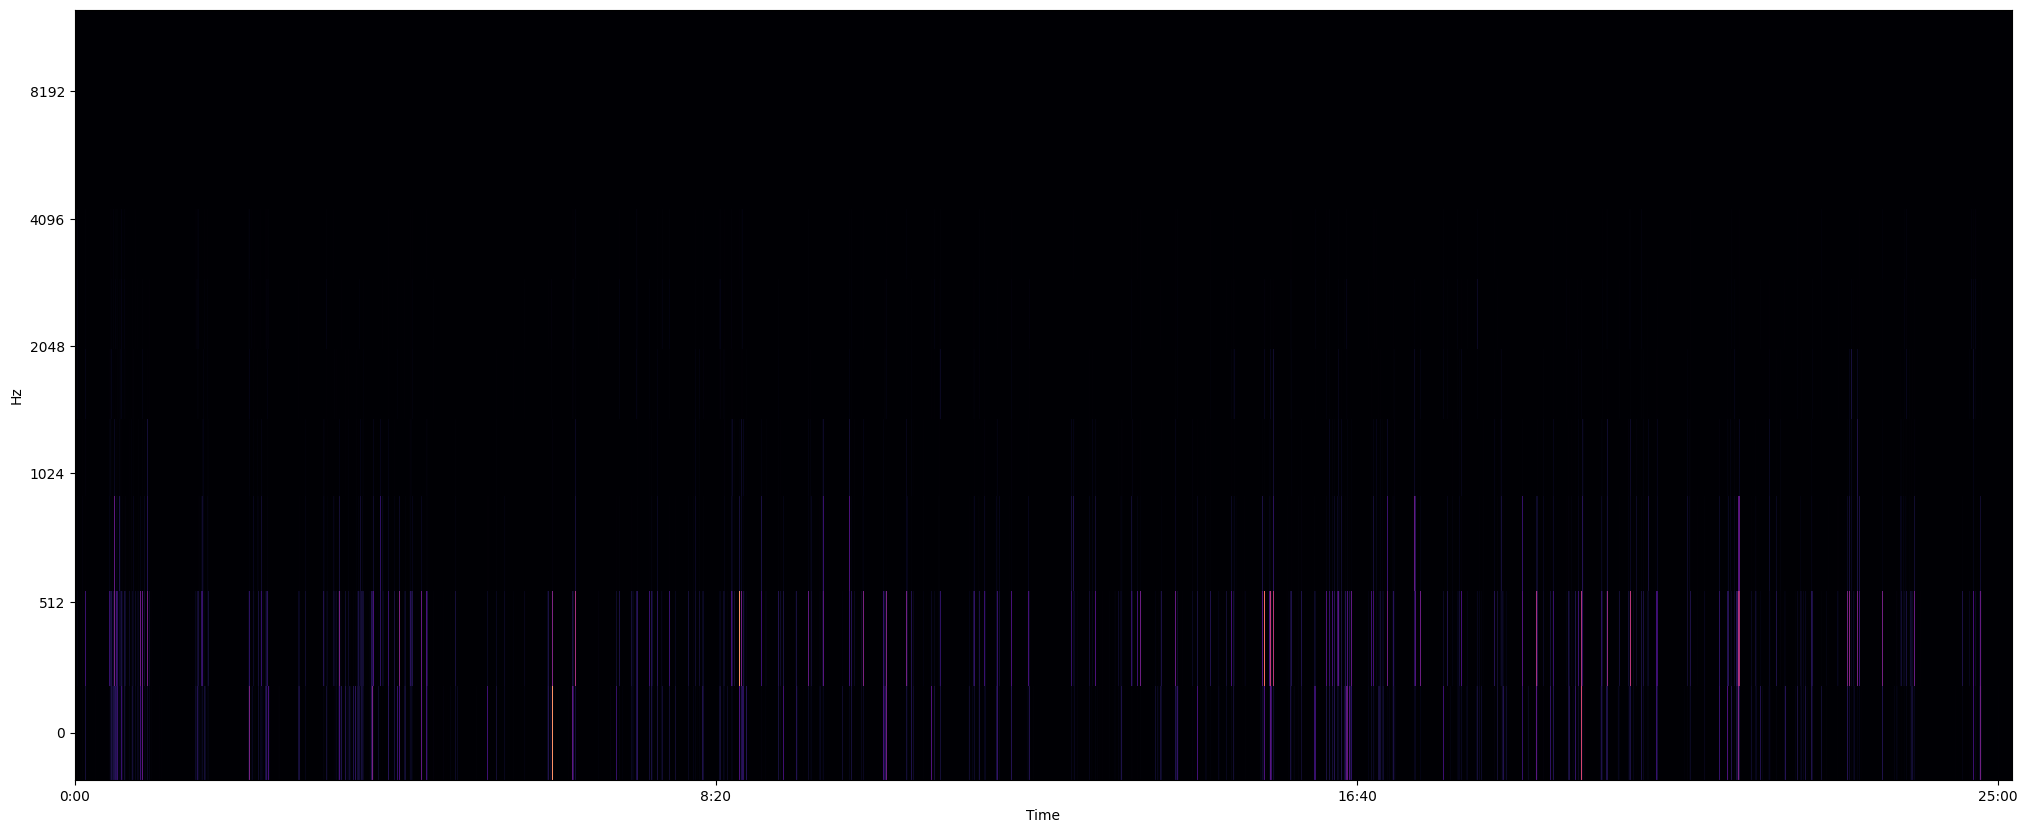

In [9]:
display(mel_spectrogram=mel_spectrogram)

In [10]:
log_mel_spectogram = librosa.power_to_db(mel_spectrogram)

In [11]:
log_mel_spectogram.shape

(10, 65066)

In [12]:
print(mel_spectrogram)

[[0.0000000e+00 5.1707977e-30 3.3721763e-18 ... 2.7315168e-12
  2.6707515e-25 9.7352719e-30]
 [0.0000000e+00 7.3581846e-30 7.3304614e-18 ... 7.3967400e-13
  3.7635674e-25 1.4371807e-30]
 [0.0000000e+00 3.6517761e-30 1.4128194e-17 ... 1.2970489e-14
  1.8691429e-25 8.7793526e-31]
 ...
 [0.0000000e+00 3.2879778e-31 9.8019134e-19 ... 4.7999629e-15
  8.7548403e-28 1.4893726e-30]
 [0.0000000e+00 1.9689048e-31 6.4176927e-23 ... 1.9387013e-15
  1.1486600e-27 1.4080174e-30]
 [0.0000000e+00 2.1156225e-31 4.7047429e-20 ... 2.0602324e-16
  9.6444206e-28 7.6006280e-31]]


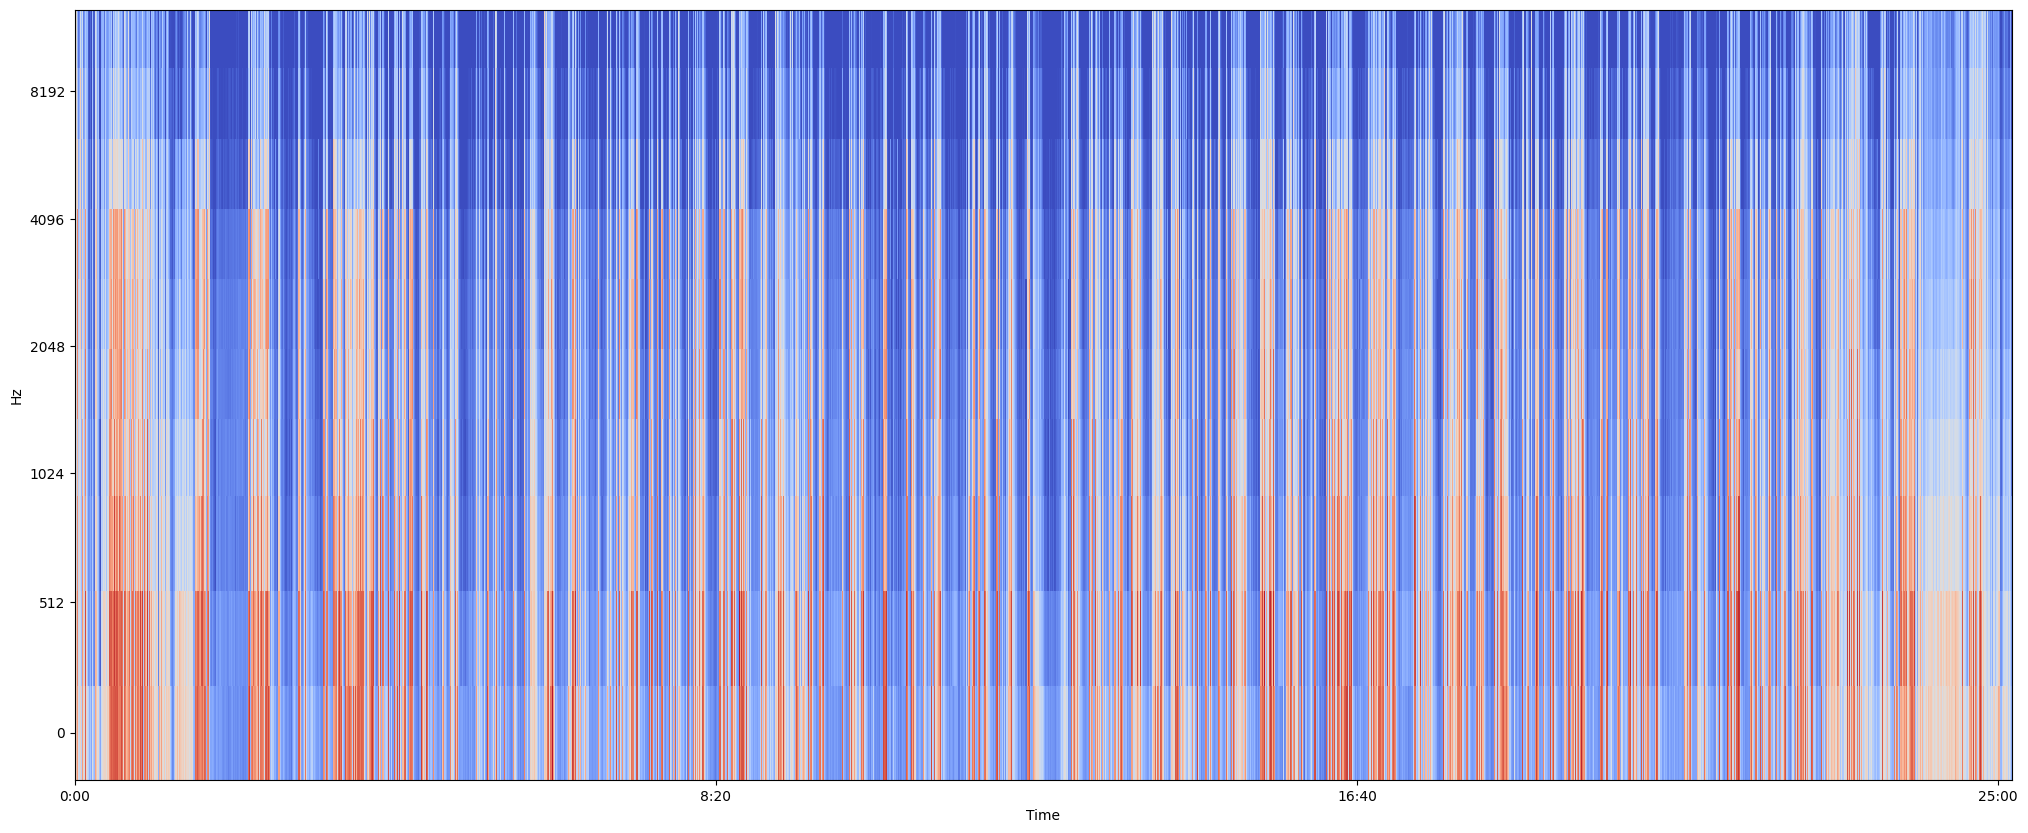

In [13]:
display(log_mel_spectogram)

## Mel spectrogram for each segment

### Calculate the total number of intervals

In [14]:
interval_length = 10
total_duration = len(scale) / sampling_rate
num_intervals = int(total_duration // interval_length)

### Calculate the Mel spectrogram for each interval

In [15]:
mel_spectrograms = list()
for interval in range(num_intervals):
    # Define the start and end index for the current interval
    start_index = interval * interval_length * sampling_rate
    end_index = (interval + 1) * interval_length * sampling_rate

    # Get the audio slice for the current interval
    interval_audio = scale[start_index:end_index]

    # Obtain the Mel spectrogram for the interval
    interval_mel_spec = librosa.feature.melspectrogram(y=interval_audio, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=10)

    interval_log_mel_spec = librosa.power_to_db(interval_mel_spec)

    # Append the Mel spectrogram to the list
    mel_spectrograms.append(interval_log_mel_spec)

In [16]:
print(mel_spectrograms[0])

[[-66.75528  -66.75528  -66.75528  ... -25.50251  -24.81837  -28.685162]
 [-66.75528  -66.75528  -66.75528  ... -27.782476 -29.268974 -36.853558]
 [-66.75528  -66.75528  -66.75528  ... -30.324242 -32.141617 -39.83205 ]
 ...
 [-66.75528  -66.75528  -66.75528  ... -29.759829 -31.424295 -37.753124]
 [-66.75528  -66.75528  -66.75528  ... -29.130192 -30.268774 -36.61678 ]
 [-66.75528  -66.75528  -66.75528  ... -31.308918 -31.839031 -37.22423 ]]


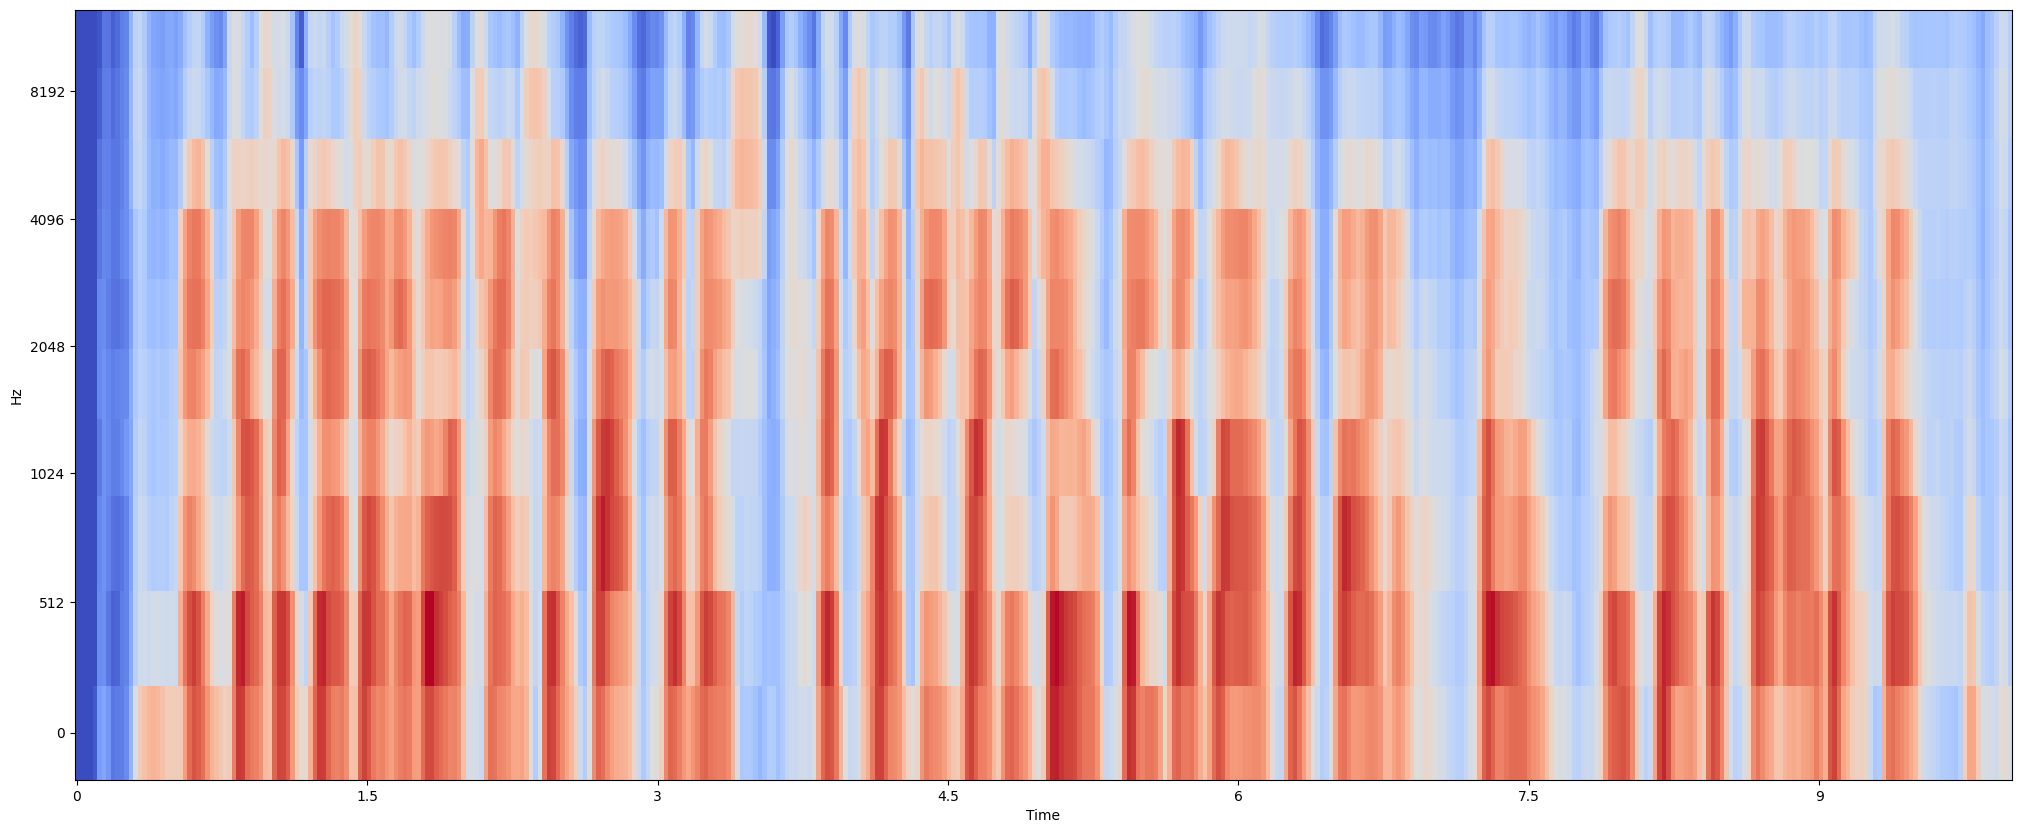

In [17]:
display(mel_spectrograms[0])

In [18]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [19]:
df = pd.read_csv('prediction.csv')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Audio ID          151 non-null    object 
 1   Start time        151 non-null    object 
 2   Highlight ID      61 non-null     object 
 3   Output Category   151 non-null    int64  
 4   Amplitude         151 non-null    float64
 5   Final prediction  151 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 7.2+ KB


In [21]:
len(mel_spectrograms)

151

In [22]:
len(df)

151

In [23]:
actual_values = df['Output Category']

In [45]:
# Convert to numpy arrays and add a channel dimension
mel_spectrograms = np.array(mel_spectrograms)
# mel_spectrograms = mel_spectrograms[..., np.newaxis]  # Add channel dimension

In [46]:
mel_train, mel_test,  actual_train, actual_test = train_test_split(mel_spectrograms, actual_values,
                                                                    random_state=104,  
                                                                    test_size=0.25,  
                                                                    shuffle=False)

In [47]:
(len(mel_train), len(mel_test), len(actual_train), len(actual_test))

(113, 38, 113, 38)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [49]:
# Input shape
# input_shape = (mel_spectrograms.shape[1], mel_spectrograms.shape[2], 1)
# input_shape
input_shape = mel_spectrograms[0].shape

In [50]:
num_classes = 2
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(mel_train, actual_train, epochs=10)

Epoch 1/10


d:\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5586 - loss: 151.1621
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4228 - loss: 90.7838
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5980 - loss: 19.3396
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6047 - loss: 11.7077
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7013 - loss: 6.6292
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7336 - loss: 6.2923
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5749 - loss: 8.3316
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7528 - loss: 4.1413
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7105 - loss: 3.6722
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7436 - loss: 5.3555


In [51]:
model.evaluate(mel_test, actual_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5910 - loss: 6.0763  


[5.8718743324279785, 0.6052631735801697]